Investigating signals of selection in the _An. stephensi_ genome

Tristan Dennis, 02/25

NOTES:
- For the gene annotation, you will want to add your own chrom labels, positions, and genes, and update the both the dict and the code in the plotting loops accordingly

TO-DO:
- Turn stevegen functions into a library for future projects (budget malariagen for those not lucky enough to have theit taxon in malariagen_data).
- Tidy up gene dict.
- Turn gene annotation into a function

In [14]:
# Set up environment

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import sgkit as sg
import json
import numba
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as sch
import hashlib
import dask
import allel; print('scikit-allel', allel.__version__)
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})


scikit-allel 1.3.13


In [ ]:
# Set up helper variables and dicts

#chrom dict
scaflens={'CM023248' : 93706023,
'CM023249' : 88747589,
'CM023250' : 22713616}

df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20250212.csv')

# Palette - this maps onto the cohort labels in the dataframe above.
pop_code_cols = {
    'APA' : '#ff7f00', #orange
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRS' : '#c27a88', #horrible fuschia pink
    'IRH' : '#c57fc9', #salmon
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'DJI' : '#507d2a', #sap green
    'ETB' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'ETW' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#khaki
}

contigs_dict = {'CM023248':0,
                'CM023249':1,
                'CM023250':2}

In [ ]:
# Define helper functions for stevegen0.5k

#takes ds, returns gwss of chrom and samples if specified
def do_gwss(
     chrom,
     analysis_name = None,
     sample_query = None,
     sample_list = None,
     numgenos = None, 
     winsize=100,
     results_dir=None,
     ):       

     # construct a key to save the results under
     results_key = hash_params(
          chrom=chrom,
          sample_list=sample_list,
          analysis_name=analysis_name,
          sample_query=sample_query,
          numgenos=numgenos,
          winsize=winsize
     )

     # define paths for results files
     data_path = f'{results_dir}/{results_key}-data.csv'

     try:
          # try to load previously generated results
          data = pd.read_csv(data_path)
          return data
     except FileNotFoundError:
          # no previous results available, need to run analysis
          print(f'running analysis: {results_key}')

     #get data
     print('setting up inputs')
     df_samples, ds_analysis = load_hap_ds(chrom=chrom,sample_query=sample_query)
     
     # load haps and do scan
     ht = allel.GenotypeArray(ds_analysis['call_genotype'])
     ht = ht.to_haplotypes()
     pos = ds_analysis['variant_position'].compute()
     hstats = allel.moving_garud_h(ht, size=winsize)
     x = allel.moving_statistic(pos, statistic=np.mean, size=winsize)       
     print(f"completed scan for {chrom}, window size {winsize}")
     
     #make df
     h123df = pd.DataFrame({'chrom' : chrom, 'midpos':x, 'h1':hstats[0],'h12':hstats[1], 'h123':hstats[2],'h1_h2':hstats[3]})

     # save results
     h123df.to_csv(data_path, index=False)
     print(f'saved results: {results_key}')

     return(h123df)

#hashing function
def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h


def select_random_genos(
                    ds, 
                    numgenos):
                     #selects given number of genos at random
                    keep_indices = np.random.choice(ds.call_genotype.shape[0], numgenos, replace=False)
                    keep_indices.sort()
                    thinned_callset = ds.isel(variants=~keep_indices)
                    return(thinned_callset)

def load_hap_ds(chrom, 
                phased=False,
                sample_query=None, 
                numgenos=None, 
                sample_list=None, 
                start=None, 
                end=None, 
                min_minor_ac=0,
                df_samples=df_samples):
                 # load sample metadata
     #load ds
     if phased:
          ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.phased.{chrom}.zarr')
     else:
          ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.zarr')

     #load annotation ds
     #annzarr = zarr.open('/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/annotations.zarr')     #if sample query or list are specified, subset accordingly

     if sample_query:
          # locate selected samples
          loc_samples = df_samples.eval(sample_query).values
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     elif sample_list:
          loc_samples = df_samples['sample_id'].isin(sample_list)
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     else:
          pass
          
     #if numgenos is set, subset 
     if numgenos:
          ds_analysis = select_random_genos(ds, numgenos)
     else:
          ds_analysis = ds

     #if region is set, subset to region
     if start:
               #subset to region of interest
              print(f"subsetting variants to range {chrom}:{start}-{end}")
              ds_analysis = ds_analysis.set_index(variants=("variant_position")).sel(variants=slice(start,end))
              #and for annotations
              #pos = allel.SortedIndex(annzarr[f'{chrom}/variants/POS'])
              #loc_region = pos.locate_range(start, end)
     #         im_region = annzarr[f'{chrom}/variants/ANN_Annotation'][loc_region]
     #         ft_region = annzarr[f'{chrom}/variants/ANN_HGVS_p'][loc_region]
     else:
            pass
     
     #if minmaf is specified, select minmaf     
     print(f'subsetting to segregating sites')
     ac = allel.GenotypeArray(ds_analysis['call_genotype']).count_alleles()
     macbool = ac[:,1] >= min_minor_ac
     print(f'selected {np.sum(macbool)} sites with a min mac > {min_minor_ac}')
     ds_analysis = ds_analysis.sel(variants=(macbool))
    # ft_maf = ft_region[macbool]
    # im_maf = im_region[macbool]
     #get accessible only
     print('subsetting to accessible sites only')
     accmask = ds_analysis['is_accessible'].compute()
     ds_analysis = ds_analysis.sel(variants=(accmask))
     #ft_acc = ft_maf[accmask]
     #im_acc = im_maf[accmask]

     #return completed ds
     return(df_samples, ds_analysis)#, ft_acc, im_acc)


In [ ]:
# Now run selection scans
winsize=1500
sels = []
for pop_code in df_samples.pop_code.unique():
    for chrom in ['CM023248', 'CM023249', 'CM023250']:
        selscan = do_gwss(chrom = chrom,
                        sample_query = f'pop_code == "{pop_code}"',
                        winsize=winsize,
                        results_dir='/Users/dennistpw/Projects/AsGARD/data/selection_20240923',
                        analysis_name=f"{pop_code}.{chrom}.{winsize}.ud2"
                        )
        #selscan = pd.DataFrame({'pop' : [analysis_pop], 'chrom':[chrom]})
        selscan['pop'] = pop_code
        print(f"completed selscan for {chrom}, {pop_code}, {winsize}")
        sels.append(selscan)

completed selscan for CM023248, APA, 1500
completed selscan for CM023249, APA, 1500
completed selscan for CM023250, APA, 1500
completed selscan for CM023248, ETB, 1500
completed selscan for CM023249, ETB, 1500
completed selscan for CM023250, ETB, 1500
completed selscan for CM023248, SUD, 1500
completed selscan for CM023249, SUD, 1500
completed selscan for CM023250, SUD, 1500
completed selscan for CM023248, ETS, 1500
completed selscan for CM023249, ETS, 1500
completed selscan for CM023250, ETS, 1500
completed selscan for CM023248, DJI, 1500
completed selscan for CM023249, DJI, 1500
completed selscan for CM023250, DJI, 1500
completed selscan for CM023248, ETW, 1500
completed selscan for CM023249, ETW, 1500
completed selscan for CM023250, ETW, 1500
completed selscan for CM023248, SAE, 1500
completed selscan for CM023249, SAE, 1500
completed selscan for CM023250, SAE, 1500
running analysis: 2b28fa50ada59c59b2714215091038a3
setting up inputs
subsetting to segregating sites
selected 8730863 

In [ ]:
# Prepare for plotting

# Concat selscan output to a big table
selscans_df = pd.concat(sels)

#prepare values for plotting
max_h1_dict = dict(selscans_df.groupby('pop')['h12'].max())
max_values = selscans_df.groupby('chrom')['midpos'].max()
total_max = max_values.sum()
column_widths = (max_values / total_max).values
col_var_levels = max_values.index

#gene regions (hacky, amend)
cyp6_region = {'CM023248': {'x_min': 67473117, 'x_max': 67501071, 'y_min': 0, 'y_max': 1}}
ace1_region = {'CM023248': {'x_min': 60904014, 'x_max': 60973023, 'y_min': 0, 'y_max': 1}}
vgsc_region = {'CM023249': {'x_min': 42817709, 'x_max': 42817800, 'y_min': 0, 'y_max': 1}}
gste_region = {'CM023249': {'x_min': 70572788, 'x_max': 70584603, 'y_min': 0, 'y_max': 1}}
rdl_region = {'CM023249': {'x_min': 8345440, 'x_max': 8348441, 'y_min': 0, 'y_max': 1}}
cyp9_region = {'CM023250': {'x_min': 9721225, 'x_max': 9722225, 'y_min': 0, 'y_max': 1}}
carboxyl_cluster = {'CM023249':{'x_min' : 18784698, 'x_max' :18801820, 'y_min': 0, 'y_max': 1}}
coejh_region = {'CM023249':{'x_min' : 26291697, 'x_max' :26310369, 'y_min': 0, 'y_max': 1}}
diagk = {'CM023250': {'x_min': 4578144, 'x_max': 4578144, 'y_min': 0, 'y_max': 1}}

#order rows for plotting
rowvars_reordered = ['SAE', 'SAR', 'IRH', 'IRS','APA', 'DJI', 'ETB', 'ETS', 'ETW', 'SUD','YEM']

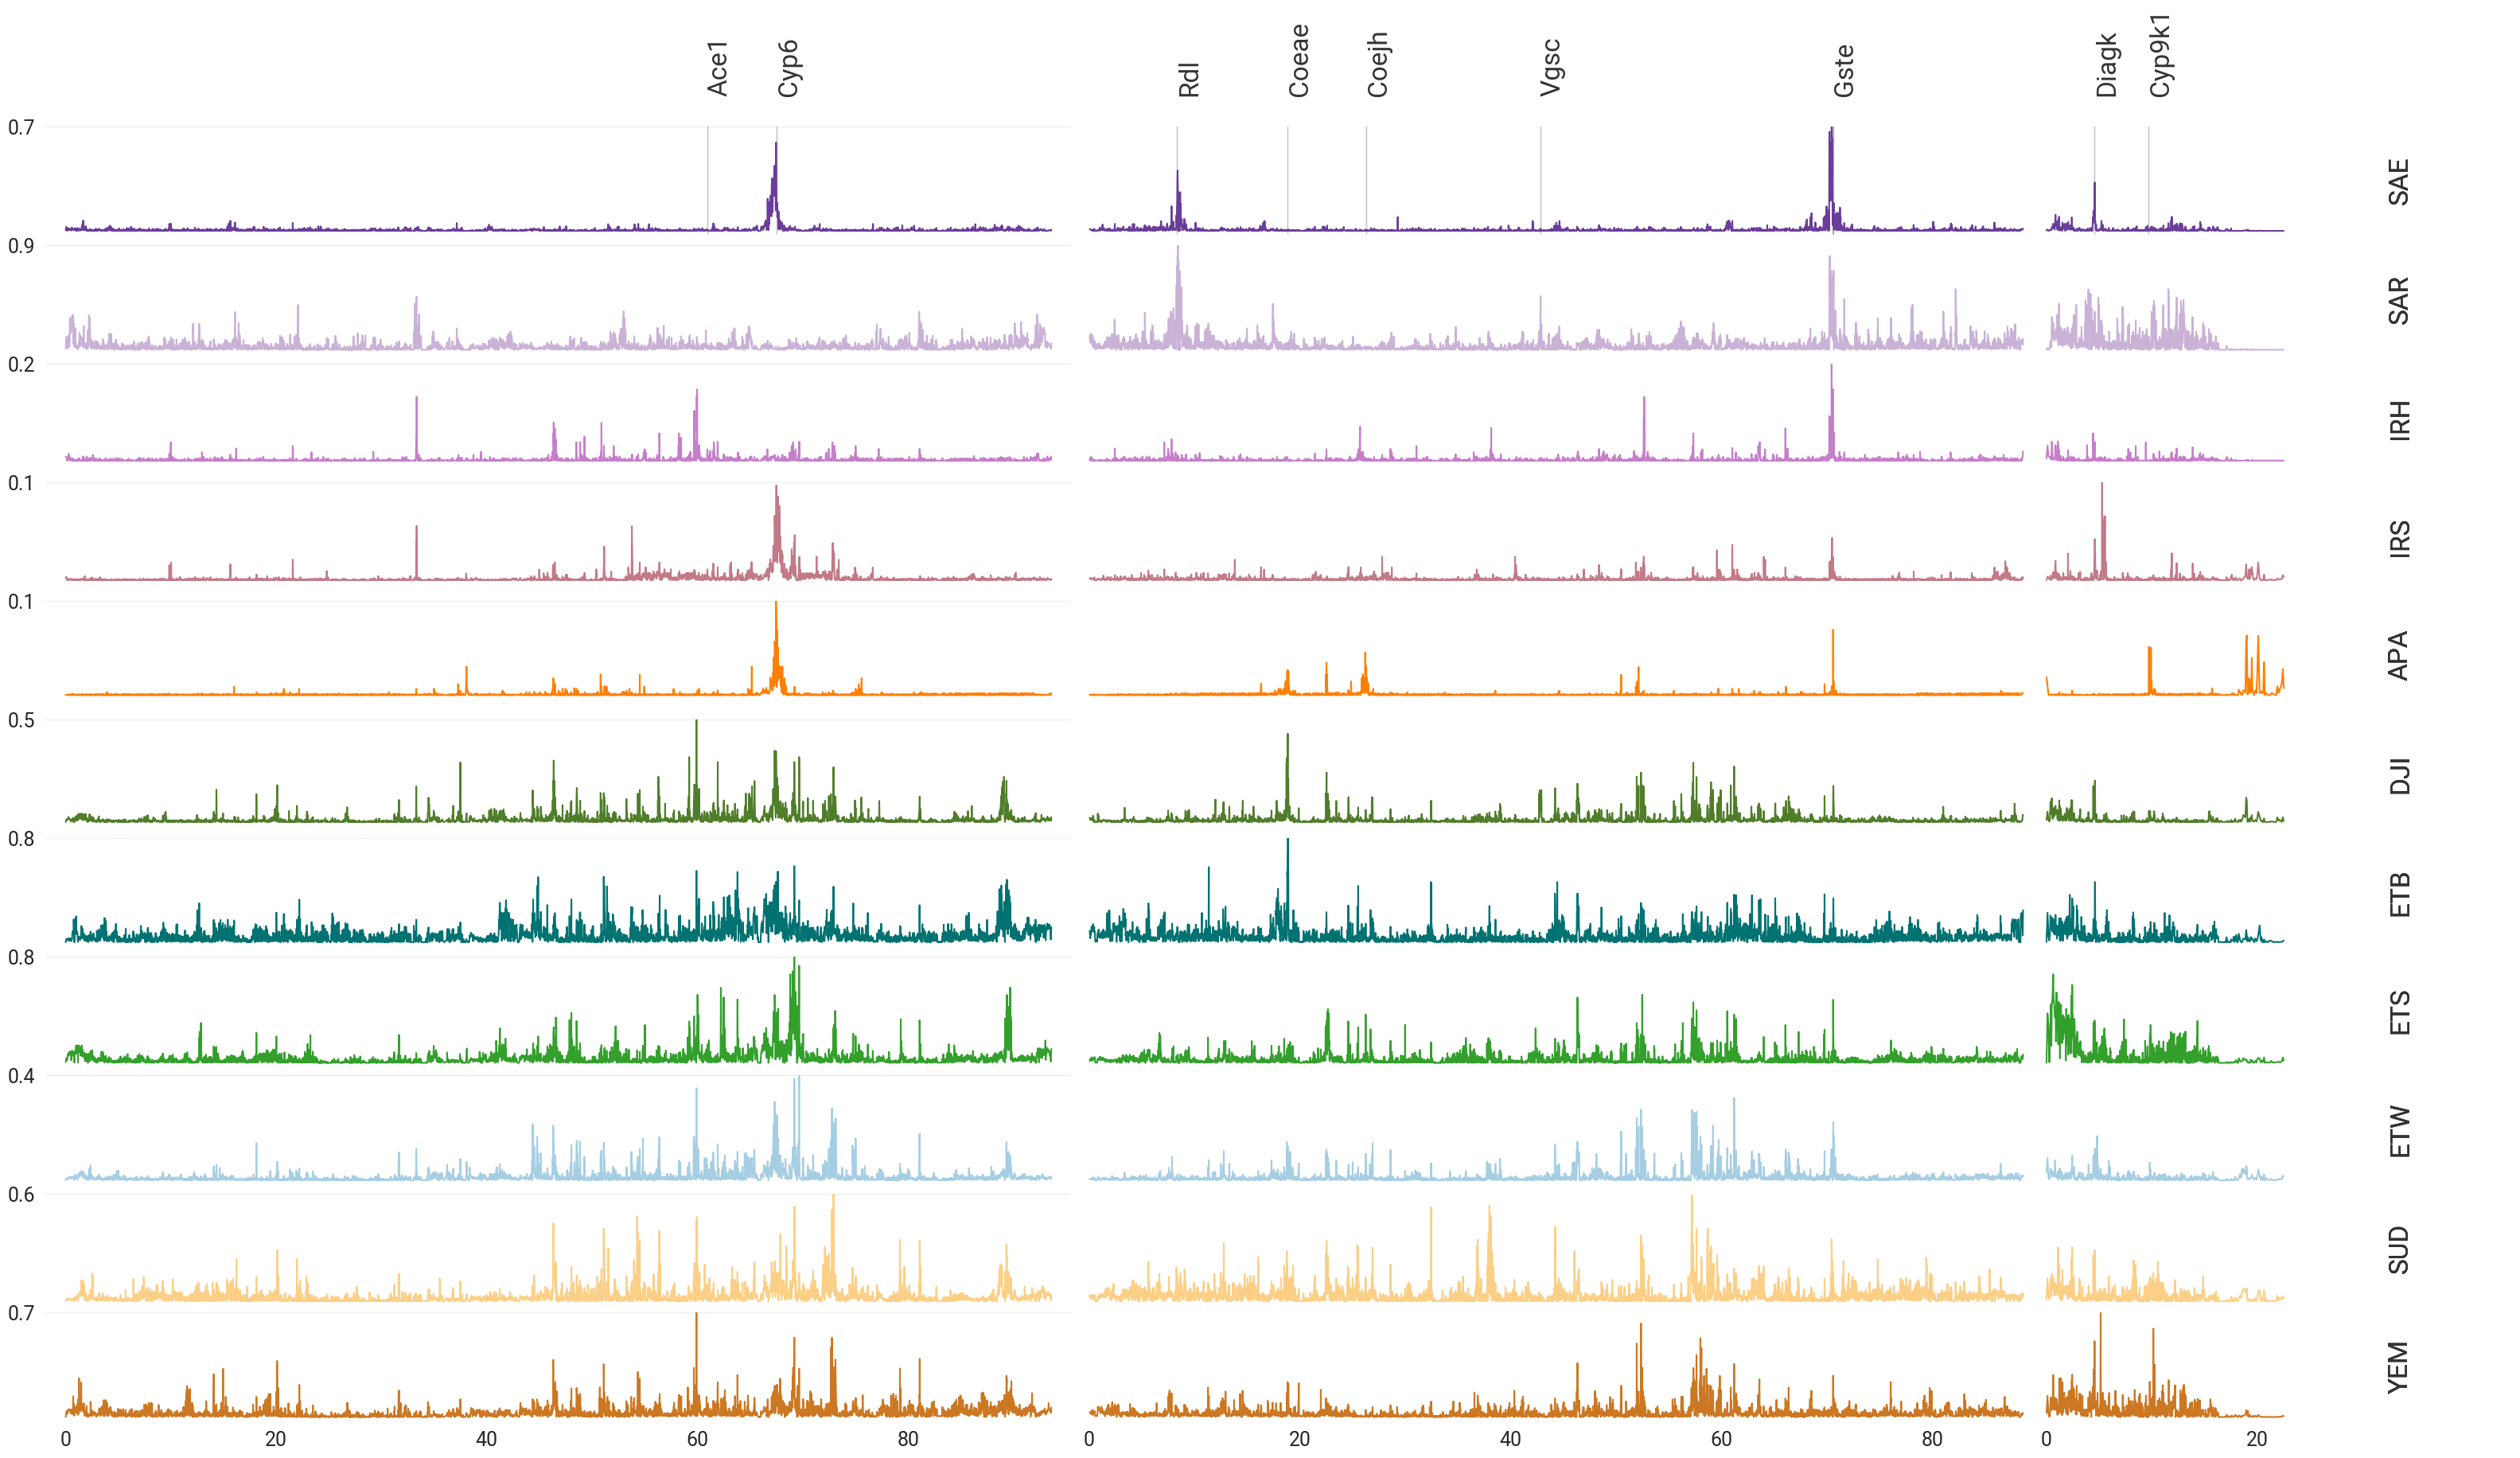

In [ ]:
# Now do the plotting - big selscan multiplot

# Get the unique row vars (populations - amend to whatever dataframe variable you have to row by)
row_var_levels = selscans_df['pop'].unique()

# Set up global axis params:
# Set y labs to 1 dp
def format_func(value, tick_number):
    return f"{value:.1f}"
# Function to format x-axis labels as integers
def format_x(value, tick_number):
    return f"{int(value / 1e6)}"  

# Initialize the figure and GridSpec
fig = plt.figure(figsize=(sum(column_widths) * 40, len(row_var_levels) * 2))  # Plots half as high
gs = GridSpec(len(row_var_levels), len(col_var_levels) + 1, width_ratios=list(column_widths) + [0.1])

# Create the subplots
for row_idx, row_val in enumerate(rowvars_reordered): # Iterate over populations
    for col_idx, col_val in enumerate(col_var_levels): #Iterate over per-pop chromosomes
        row_colour = pop_code_cols.get(row_val, 'black')  # Look up colour in dictionary
        ax = fig.add_subplot(gs[row_idx, col_idx])
        subset = selscans_df[(selscans_df['pop'] == row_val) & (selscans_df['chrom'] == col_val)] # Subset df to contain only data for that chrom and cohort
        sns.lineplot(data=subset, x='midpos', y='h12', ax=ax, linewidth=1.5, color=row_colour) # Plot lineplot

        #ax.fill_between(x=subset['midpos'], y1=subset['h12'], color=row_colour, alpha=0.1)  #  This is nice if you have inversions or massive sweeps where some colour underneath the line is helpful - commented out for me as was too busy

        # Tinker with the axes:
        ax.yaxis.set_major_formatter(FuncFormatter(format_func))

        # Despine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Tidy up axis ticks and labels
        #ax.set_ylim(0, 1)  #set max on y to 1 -  ensures consistency across all plots - easier if your sweeps are all kind of the same size.
        ax.set_ylim(0, max_h1_dict[row_val])  #set max on y to be max h1 for each pop - this emphasises the sweep signal in weakly swept pops/regions but we must note in the legend!
        plt.yticks([max_h1_dict[row_val]]) # Plot only the max y value as a tick - remove axis clutter - delete or amend as appropriate
        plt.ylabel('') # No Y label - will add myself in inkscape


        # Remove y-axis for 2nd and 3rd columns
        if col_idx > 0:
            ax.set_ylabel('')
            ax.yaxis.set_visible(False)

        for ax in fig.get_axes():
            ax.tick_params(axis='both', labelsize=18)  # Increase font size of both x and y tick labels

        # Remove x-axis titles and replace with chromosome numbering
        ax.set_xlabel('')
        if row_idx == 11:
            if col_idx == 0:
                ax.set_xlabel("2", fontsize=24, fontweight='bold')
            elif col_idx == 1:
                ax.set_xlabel("3", fontsize=24, fontweight='bold')
            elif col_idx == 2:
                ax.set_xlabel("X", fontsize=24, fontweight='bold')    # Add the row title


                
        # Set x-axis ticks at increments of 2e7
        max_x = selscans_df[selscans_df['chrom'] == col_val]['midpos'].max()
        ax.set_xticks(range(0, int(max_x) + 1, 20_000_000))
        ax.xaxis.set_major_formatter(FuncFormatter(format_x))

        # Hide x-axis labels for non-bottom plots
        if row_idx < len(rowvars_reordered) - 1:
            ax.xaxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)

        #remove x axes except bottom one
        if row_idx < len(rowvars_reordered) - 1:
            ax.xaxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis ticks and labels

        plt.subplots_adjust(top=0.85) 

        # Add row (population) labels
        row_ax = fig.add_subplot(gs[row_idx, -1])
        row_ax.text(0.5, 0.5, row_val, va='center', ha='center', fontsize=24, rotation=90, transform=row_ax.transAxes)
        row_ax.axis('off')

        # Adjust position of facet labels (move them closer to the plot)
        if row_idx == 0:  # Adjust position for row labels (facet labels)
            row_ax.set_position([row_ax.get_position().x0, row_ax.get_position().y0 + 0.05, row_ax.get_position().width, row_ax.get_position().height])

        # Now, annotate plots - theere is prob a better way to do this...in a function?

        # Add text annotations and lines for IR genes - needs to be done by chromosome/pos/gene mapping in the dict above
        if col_val == 'CM023248' and row_idx == 0:
            # Cyp6
            ax.fill_betweenx([cyp6_region[col_val]['y_min'], cyp6_region[col_val]['y_max']],
                cyp6_region[col_val]['x_min'], cyp6_region[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(cyp6_region[col_val]['x_min'], 1, "Cyp6", fontsize=24, rotation=90)
            # Ace1
            ax.text(ace1_region[col_val]['x_min'], 1, "Ace1", fontsize=24, rotation=90)
            ax.fill_betweenx([ace1_region[col_val]['y_min'], ace1_region[col_val]['y_max']],
                ace1_region[col_val]['x_min'], ace1_region[col_val]['x_max'],
                color='gray', alpha=0.5)

        elif col_val == 'CM023249' and row_idx == 0:
            #Vgsc
            ax.fill_betweenx([vgsc_region[col_val]['y_min'], vgsc_region[col_val]['y_max']],
                vgsc_region[col_val]['x_min'], vgsc_region[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(vgsc_region[col_val]['x_min'], 1, "Vgsc", fontsize=24, rotation=90)

            #Gste
            ax.fill_betweenx([gste_region[col_val]['y_min'], gste_region[col_val]['y_max']],
                gste_region[col_val]['x_min'], gste_region[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(gste_region[col_val]['x_min'], 1, "Gste", fontsize=24, rotation=90)

            #Rdl
            ax.fill_betweenx([rdl_region[col_val]['y_min'], rdl_region[col_val]['y_max']],
                rdl_region[col_val]['x_min'], rdl_region[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(rdl_region[col_val]['x_min'],1, "Rdl", fontsize=24, rotation=90)

            #Coeae
            ax.fill_betweenx([carboxyl_cluster[col_val]['y_min'], carboxyl_cluster[col_val]['y_max']],
                            carboxyl_cluster[col_val]['x_min'], carboxyl_cluster[col_val]['x_max'],
                            color='gray', alpha=0.5)
            ax.text(carboxyl_cluster[col_val]['x_min'], 1, "Coeae", fontsize=24, rotation=90)

            #CoeJH
            ax.fill_betweenx([coejh_region[col_val]['y_min'], coejh_region[col_val]['y_max']],
                            coejh_region[col_val]['x_min'], coejh_region[col_val]['x_max'],
                            color='gray', alpha=0.5)
            ax.text(coejh_region[col_val]['x_min'], 1, "Coejh", fontsize=24, rotation=90)

        elif col_val == 'CM023250' and row_idx == 0:
            #Cyp9k1
            ax.fill_betweenx([cyp9_region[col_val]['y_min'], cyp9_region[col_val]['y_max']],
                cyp9_region[col_val]['x_min'], cyp9_region[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(cyp9_region[col_val]['x_min'], 1, "Cyp9k1", fontsize=24, rotation=90)

            #Diagk
            ax.fill_betweenx([diagk[col_val]['y_min'], diagk[col_val]['y_max']],
                diagk[col_val]['x_min'], diagk[col_val]['x_max'],
                color='gray', alpha=0.5)
            ax.text(diagk[col_val]['x_min'], 1, "Diagk", fontsize=24, rotation=90)


plt.subplots_adjust(wspace=0, hspace=0.1)  # Reduce column and row padding

fig.savefig('../figures/h12.svg')

plt.show()

#save as svg

## Haplotype clustering
Now let's take a look at some haplotype clustering dendrograms to see whether regions apparently under selection are shared between populations

In [31]:
#define some clustering and plotting functions
#get dist
@numba.njit(parallel=True)
def pdist_abs_hamming(X):
    n_obs = X.shape[0]
    n_ftr = X.shape[1]
    out = np.zeros((n_obs, n_obs), dtype=np.int32)
    for i in range(n_obs):
        x = X[i]
        for j in numba.prange(i + 1, n_obs):
            y = X[j]
            d = 0
            for k in range(n_ftr):
                if x[k] != y[k]:
                    d += 1
            out[i, j] = d
            out[j, i] = d
    return out

def plot_dendrogram(h, ax, df_samples):

    #Helper vars I am not fussed about
    color_threshold=0
    above_threshold_color='k'
    linkage_method = 'single'
    distance_sort=True
    count_sort=True

    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # Hierarchical clustering.
    Z = sch.linkage(dist, method=linkage_method)

        #harmonise metadata with samples
    # Align sample metadata with haplotypes.

    # Repeat the dataframe so there is one row of metadata for each haplotype.
    leaf_data = pd.DataFrame(np.repeat(df_samples.values, 2, axis=0))
    leaf_data.columns = df_samples.columns

    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    # Compute the dendrogram but don't plot it.
    dend = sch.dendrogram(
        Z,
        count_sort=count_sort,
        distance_sort=distance_sort,
        no_plot=False,
        color_threshold=color_threshold,
        above_threshold_color=above_threshold_color,
    )

    ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.despine(ax=None, fig=None, offset=5, left=True, bottom=True, top=True, right=True)
    ax.set_ylim(bottom=-2)
    ax.set_ylabel('')
    ax.autoscale(axis='x', tight=True)

    return Z, dend, leaf_data

def return_persample_het(haps):
    return([np.nanmean(allel.heterozygosity_observed(haps[:, [i], :])) for i in range(haps.shape[1])])


def fig_hap_structure(h, df_samples=df_samples, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(8, 3), 
                      fn=None, dpi=150, height_ratios=(0.6, .1, .1), hap_pops=None, legend=False, title=None):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 3
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # get per-sample mean het
    het = return_persample_het(h)

    df_samples['sample_het'] = het

    # make haps
    h = h.to_haplotypes()

    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r, leafdata = plot_dendrogram(h, ax_dend, df_samples)
    ax_dend.set_ylim(bottom=-5)
    if legend:
        handles = [mpl.patches.Patch(color=pop_code_cols[pop], label=pop) for pop in pop_code_cols.keys()]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.set(xticklabels=[])
    ax_dend.set_title(title,fontdict={'fontsize':18}, loc='right')

    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    ax_dend.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins = 3))


    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = leafdata.pop_code.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_code_cols[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=2, left=True, bottom=True, top=True, right=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')


    #add heterozygosity per-sample
    #ax_het = fig.add_subplot(gs[2, 0])
    #hetdat = np.array(leafdata['sample_het'], dtype=float)
    #hetcols = plt.cm.Greys(hetdat)
    #ax_het.broken_barh(
        #yrange=(0, 1), 
    ##    xranges=[(i, 1) for i in range(h.shape[1])], 
    #    color=hetcols
    #)
    #sns.despine(ax=ax_het, offset=2, left=True, bottom=True, top=True, right=True)
    #ax_het.set_xticks([])
    #ax_het.set_yticks([])
    #ax_het.set_xlim(0, h.shape[1])

    #ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    fig.savefig(f'../figures/{title}.svg')

In [19]:
#60904014, 'end': 60973023
chrom = genes_main['Ace1']['chrom']
start = genes_main['Ace1']['start']
end = genes_main['Ace1']['end']

ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.phased.zarr')
ds_analysis = ds.set_index(variants=("variant_position")).sel(variants=(slice(start,end)))
het = return_persample_het(ds_analysis['call_genotype'])
df_samples['het'] = het


subsetting variants to range CM023248:60904014-60973023
subsetting to segregating sites
selected 5464 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023249:18779698-18804511
subsetting to segregating sites
selected 1777 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023249:70582788-70594603
subsetting to segregating sites
selected 814 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023248:67470071-67514071
subsetting to segregating sites
selected 1727 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023249:42804885-42848176
subsetting to segregating sites
selected 2824 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023249:8345440-8348441
subsetting to segregating sites
selected 270 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


subsetting variants to range CM023250:9713374-9729212
subsetting to segregating sites
selected 795 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/687608412.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


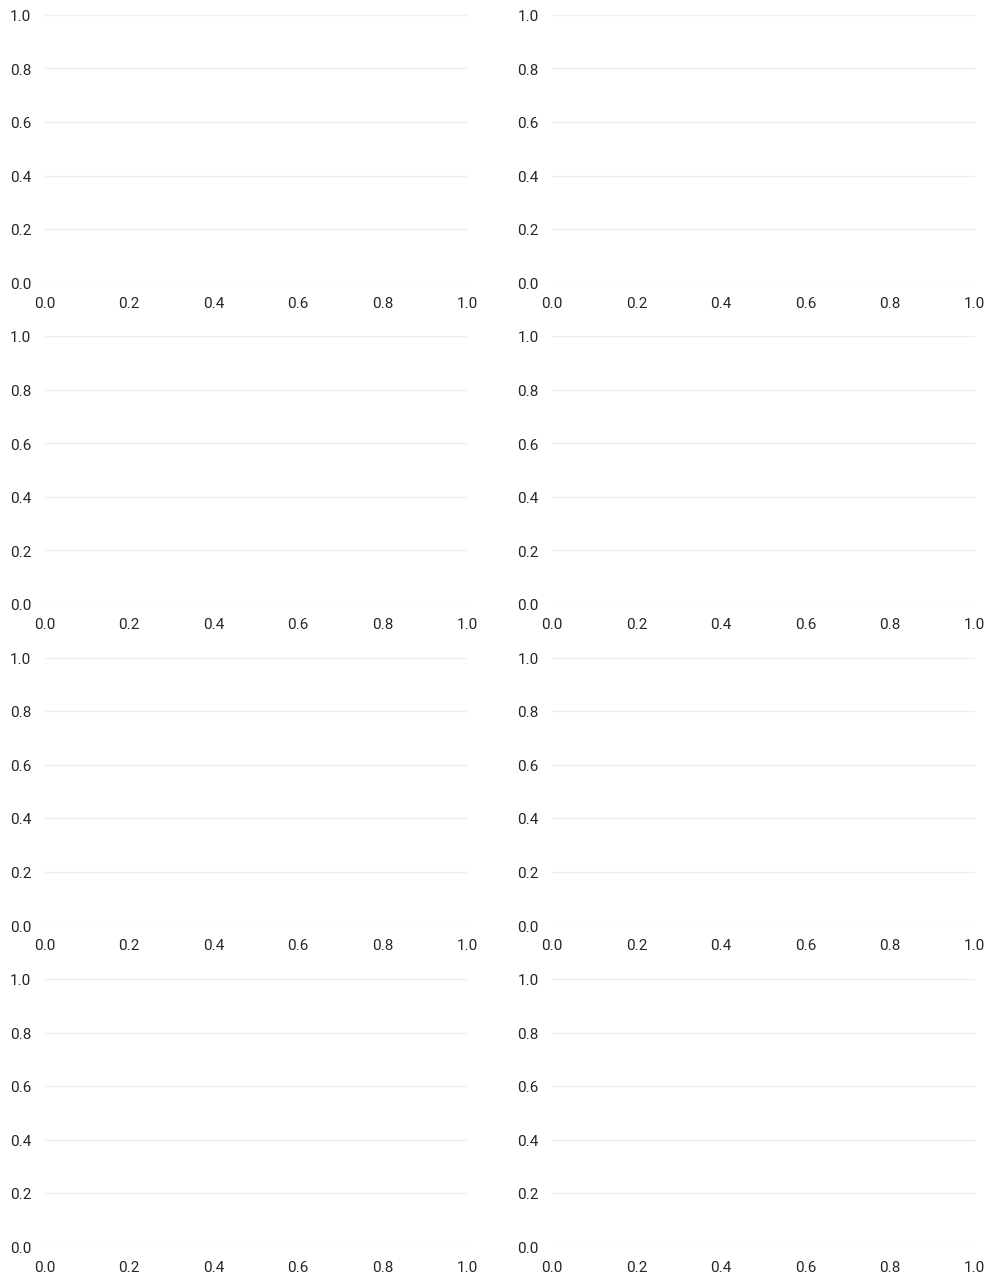

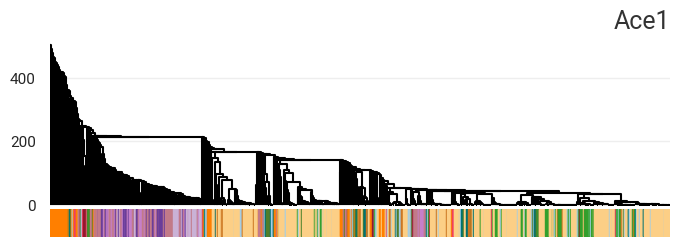

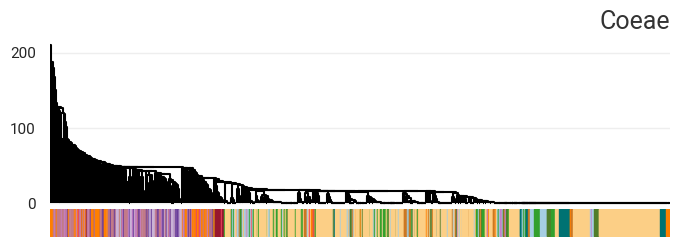

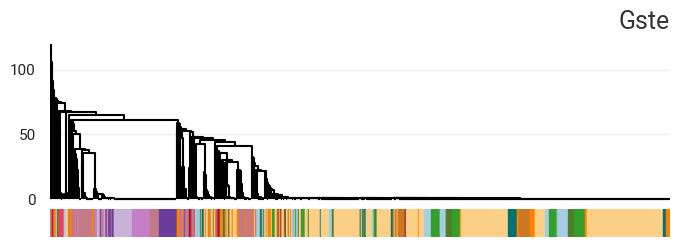

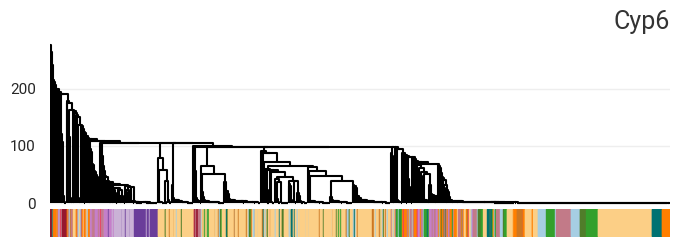

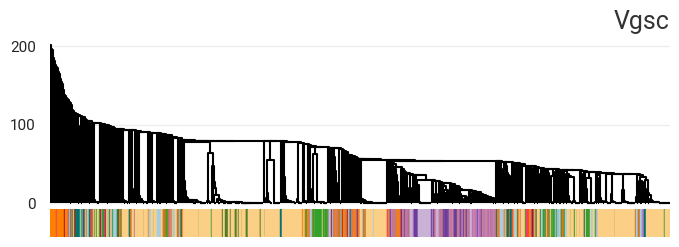

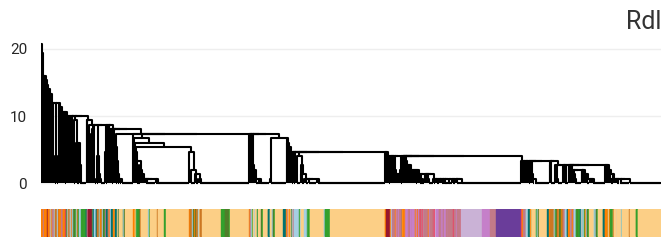

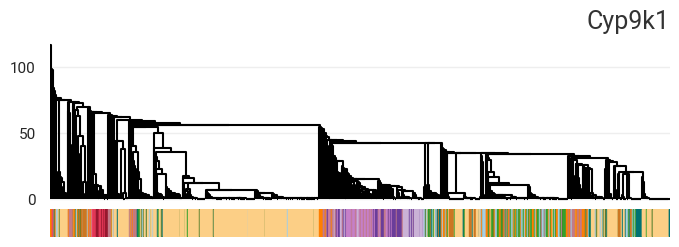

In [32]:
# Create a figure with 8 subplots (4 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

# Flatten axs for easy iteration
#axs = axs.flatten()

# Loop through genes and plot dendrograms in subplots
for i, (gene, params) in enumerate(genes_main.items()):
    haps = load_hap_ds(chrom=params['chrom'], start=params['start'], end=params['end'], min_minor_ac=1)
    ht = allel.GenotypeArray(haps[1]['call_genotype'])

    # Pass the correct subplot axis to the plotting function
    fig_hap_structure(h=ht, df_samples=df_samples, title=gene)

subsetting variants to range CM023248:60904014-60973023
subsetting to segregating sites
selected 5464 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting variants to range CM023249:18779698-18804511
subsetting to segregating sites
selected 1777 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting variants to range CM023249:70582788-70594603
subsetting to segregating sites
selected 814 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting variants to range CM023248:67470071-67514071
subsetting to segregating sites
selected 1727 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting variants to range CM023249:42804885-42848176
subsetting to segregating sites
selected 2824 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting variants to range CM023249:8345440-8348441
subsetting to segregating sites
selected 270 sites with a min mac > 1
subsetting to accessible sites only
subsetting variants to range CM023250:9713374-9729212


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


subsetting to segregating sites
selected 795 sites with a min mac > 1
subsetting to accessible sites only


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_38771/2183171031.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int))


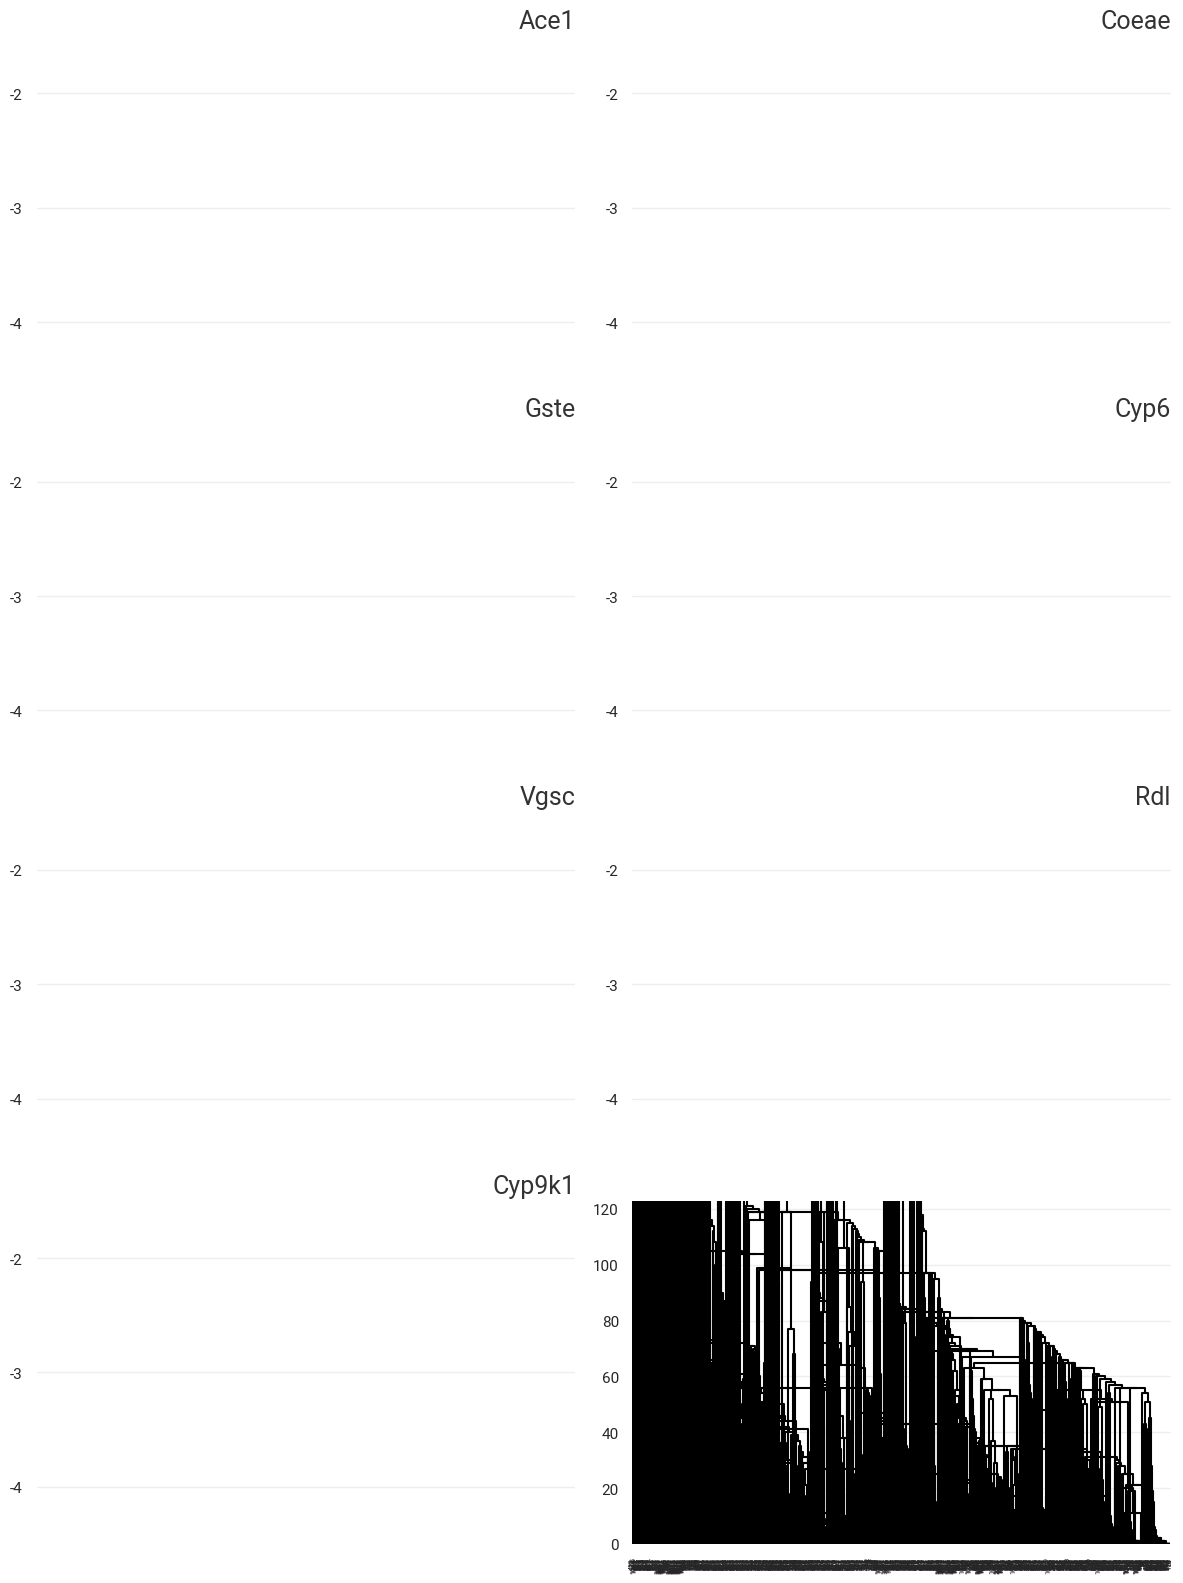

In [ ]:
def fig_hap_structure(h, df_samples=df_samples, title=None, ax=None):

    
    # If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure  # Get the parent figure of the provided axis
    
    # get per-sample mean heterozygosity
    het = return_persample_het(h)
    df_samples['sample_het'] = het

    # convert to haplotypes
    h = h.to_haplotypes()

    # dendrogram
    z, r, leafdata = plot_dendrogram(h, ax, df_samples)
    ax.set_ylim(bottom=-5)

#    if legend:
#        handles = [mpl.patches.Patch(color=pop_code_cols[pop], label=pop) for pop in pop_code_cols.keys()]
#        ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)

    ax.set_yticklabels(ax.get_yticks().astype(int))
    ax.set(xticklabels=[])
    ax.set_title(title, fontdict={'fontsize': 18}, loc='right')

    ax.xaxis.set_tick_params(length=3, pad=2)
    ax.yaxis.set_tick_params(length=3, pad=2)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3))

    return fig  # Return the figure

# Create a figure with 8 subplots (4 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axs = axs.flatten()  # Flatten for easy iteration

for i, (gene, params) in enumerate(genes_main.items()):
    haps = load_hap_ds(chrom=params['chrom'], start=params['start'], end=params['end'], min_minor_ac=1)
    ht = allel.GenotypeArray(haps[1]['call_genotype'])

    # Pass the subplot axis to the function
    fig_hap_structure(h=ht, df_samples=df_samples, title=gene, ax=axs[i])

plt.tight_layout()
plt.show()


In [ ]:
def plot_missense_haplotypes(ax, haps, mut_labels, known_muts = 'G94S'):

    ht = allel.GenotypeArray(haps[1]['call_genotype']).to_haplotypes()
    hap_indices = np.where(np.isin(known_muts, haps[2]))[0]
    h = ht.compress(hap_indices)
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    #known_muts = ['L976F', 'F1638Y','W1557R','P1842S']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = known_muts
    ax.set_yticklabels(lbl, family='monospace', fontsize=6, color='black')
    #ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='darkgrey', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)


fig, ax = plt.subplots()
missense_mutations = ['P1842S', 'F1638Y','W1557R','L976F']
plot_missense_haplotypes(ax, haps, haps[2], known_muts=['G94S'])